Problem 2: Customized Multi-View Dataset (30 pts)

100%|██████████| 9.91M/9.91M [00:42<00:00, 232kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 33.1kB/s]
100%|██████████| 1.65M/1.65M [00:04<00:00, 359kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.92MB/s]


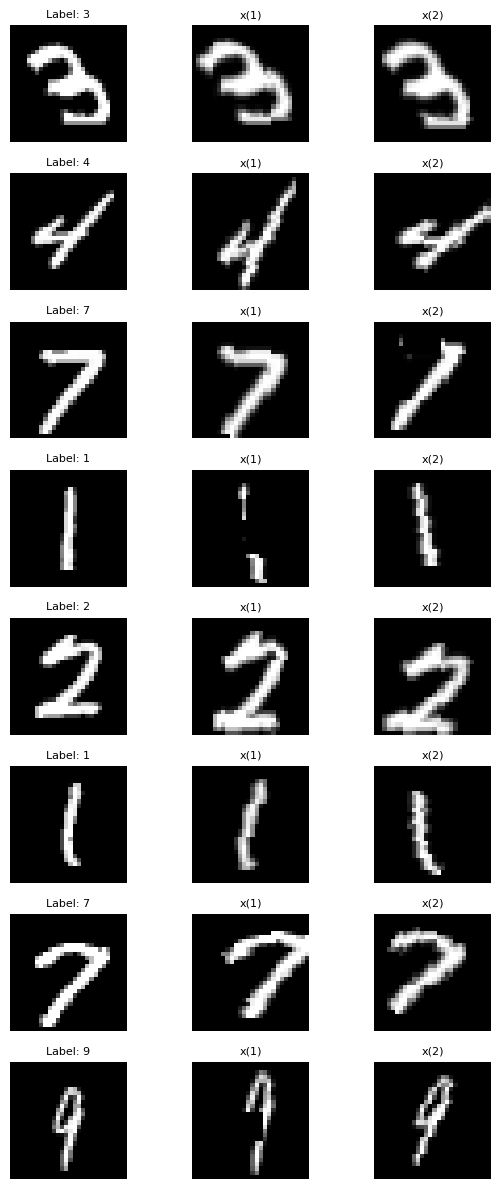

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Utility class: apply the same transform pipeline twice with independent randomness
class TwoViewTransform:
    def __init__(self, base_transform):
        self.base_transform = base_transform
    def __call__(self, x):
        return self.base_transform(x), self.base_transform(x)

# Custom dataset
class MNISTTwoView(Dataset):
    def __init__(self, root="./data", train=True, download=True):
        # Keep the original MNIST image as a tensor
        self.orig_transform = transforms.ToTensor()

        # Random augmentation pipeline
        base_transform = transforms.Compose([
            transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),
            transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), shear=10),
            transforms.ToTensor(),
            transforms.RandomErasing(p=0.25, scale=(0.02, 0.1), ratio=(0.3, 3.3))
        ])
        self.two_view_transform = TwoViewTransform(base_transform)

        # Load MNIST dataset
        self.mnist = datasets.MNIST(root=root, train=train, download=download)

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        img, label = self.mnist[idx]
        orig = self.orig_transform(img)
        x1, x2 = self.two_view_transform(img)
        return orig, x1, x2, label

# Visualization of one minibatch
if __name__ == "__main__":
    dataset = MNISTTwoView(train=True, download=True)
    loader = DataLoader(dataset, batch_size=8, shuffle=True)

    # Take one minibatch
    orig, x1, x2, labels = next(iter(loader))

    # Plot: each row = one example (original, x(1), x(2))
    fig, axes = plt.subplots(8, 3, figsize=(6, 12))
    for i in range(8):
        # Original image + label
        axes[i, 0].imshow(orig[i, 0].numpy(), cmap="gray")
        axes[i, 0].set_title(f"Label: {labels[i].item()}", fontsize=8)
        axes[i, 0].axis("off")

        # First augmented view
        axes[i, 1].imshow(x1[i, 0].numpy(), cmap="gray")
        axes[i, 1].set_title("x(1)", fontsize=8)
        axes[i, 1].axis("off")

        # Second augmented view
        axes[i, 2].imshow(x2[i, 0].numpy(), cmap="gray")
        axes[i, 2].set_title("x(2)", fontsize=8)
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

Problem 3: Logistic Regression using Gradient and Newton’s Methods (30 pts)

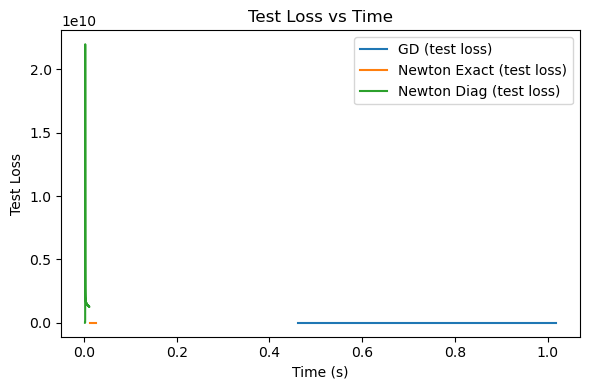

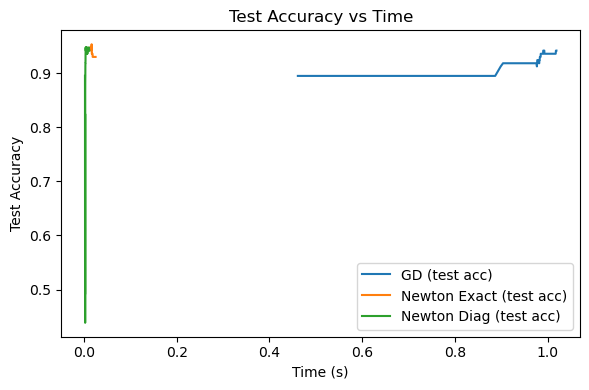

In [2]:
import time
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ---------- Helpers ----------
def bce_loss_logits(logits, y):
    """Binary cross entropy with logits (numerically stable)."""
    return nn.functional.binary_cross_entropy_with_logits(logits, y)

def accuracy_from_logits(logits, y):
    preds = (torch.sigmoid(logits) >= 0.5).float()
    return (preds.eq(y).float().mean().item())

def prepare_data(test_size=0.3, seed=0):
    """Load and preprocess Breast Cancer dataset."""
    X, y = load_breast_cancer(return_X_y=True)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=seed, stratify=y
    )
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Convert to torch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
    return X_train, y_train, X_test, y_test

# ---------- Gradient Descent ----------
def gradient_descent(lr=0.1, max_iter=200):
    Xtr, ytr, Xte, yte = prepare_data()
    N, d = Xtr.shape
    w = torch.zeros((d,1), dtype=torch.float32, requires_grad=True)

    tr_loss, te_loss, te_acc, times = [], [], [], []
    t0 = time.time()
    for it in range(max_iter):
        logits = Xtr @ w
        loss = bce_loss_logits(logits, ytr)
        loss.backward()
        with torch.no_grad():
            w -= lr * w.grad
        w.grad.zero_()

        with torch.no_grad():
            tr_loss.append(loss.item())
            te_logits = Xte @ w
            te_loss.append(bce_loss_logits(te_logits, yte).item())
            te_acc.append(accuracy_from_logits(te_logits, yte))
            times.append(time.time() - t0)
    return tr_loss, te_loss, te_acc, times

# ---------- Newton (Exact Hessian) ----------
def newton_exact(max_iter=30, damping=1e-6):
    Xtr, ytr, Xte, yte = prepare_data()
    N, d = Xtr.shape
    w = torch.zeros((d,1), dtype=torch.float32)

    tr_loss, te_loss, te_acc, times = [], [], [], []
    t0 = time.time()
    for it in range(max_iter):
        with torch.no_grad():
            logits = Xtr @ w
            p = torch.sigmoid(logits)

        grad = Xtr.T @ (p - ytr)  # gradient [d,1]
        R = (p * (1 - p)).squeeze(1)          # diag terms
        XR = Xtr * R.unsqueeze(1)             # [N,d]
        H = Xtr.T @ XR                        # Hessian [d,d]
        H = H + damping * torch.eye(d)        # damping for stability

        step = torch.linalg.solve(H, grad)
        w = w - step

        with torch.no_grad():
            tr_loss.append(bce_loss_logits(Xtr @ w, ytr).item())
            te_logits = Xte @ w
            te_loss.append(bce_loss_logits(te_logits, yte).item())
            te_acc.append(accuracy_from_logits(te_logits, yte))
            times.append(time.time() - t0)
    return tr_loss, te_loss, te_acc, times

# ---------- Newton (Diagonal Approximation) ----------
def newton_diag(max_iter=80, lr=1.0, eps=1e-8):
    Xtr, ytr, Xte, yte = prepare_data()
    N, d = Xtr.shape
    w = torch.zeros((d,1), dtype=torch.float32)

    tr_loss, te_loss, te_acc, times = [], [], [], []
    t0 = time.time()
    for it in range(max_iter):
        with torch.no_grad():
            logits = Xtr @ w
            p = torch.sigmoid(logits)

        grad = Xtr.T @ (p - ytr)  # [d,1]
        R = (p * (1 - p)).squeeze(1)
        diagH = (Xtr.pow(2) * R.unsqueeze(1)).sum(dim=0, keepdim=True).T
        step = grad / (diagH + eps)  # elementwise
        w = w - lr * step

        with torch.no_grad():
            tr_loss.append(bce_loss_logits(Xtr @ w, ytr).item())
            te_logits = Xte @ w
            te_loss.append(bce_loss_logits(te_logits, yte).item())
            te_acc.append(accuracy_from_logits(te_logits, yte))
            times.append(time.time() - t0)
    return tr_loss, te_loss, te_acc, times

# ---------- Main Experiment ----------
if __name__ == "__main__":
    gd_tr, gd_te, gd_acc, gd_t = gradient_descent(lr=0.1, max_iter=200)
    nx_tr, nx_te, nx_acc, nx_t = newton_exact(max_iter=30)
    nd_tr, nd_te, nd_acc, nd_t = newton_diag(max_iter=80, lr=1.0)

    # Plot Loss vs Time
    plt.figure(figsize=(6,4))
    plt.plot(gd_t, gd_te, label="GD (test loss)")
    plt.plot(nx_t, nx_te, label="Newton Exact (test loss)")
    plt.plot(nd_t, nd_te, label="Newton Diag (test loss)")
    plt.xlabel("Time (s)"); plt.ylabel("Test Loss")
    plt.legend(); plt.title("Test Loss vs Time")
    plt.tight_layout(); plt.show()

    # Plot Accuracy vs Time
    plt.figure(figsize=(6,4))
    plt.plot(gd_t, gd_acc, label="GD (test acc)")
    plt.plot(nx_t, nx_acc, label="Newton Exact (test acc)")
    plt.plot(nd_t, nd_acc, label="Newton Diag (test acc)")
    plt.xlabel("Time (s)"); plt.ylabel("Test Accuracy")
    plt.legend(); plt.title("Test Accuracy vs Time")
    plt.tight_layout(); plt.show()
    

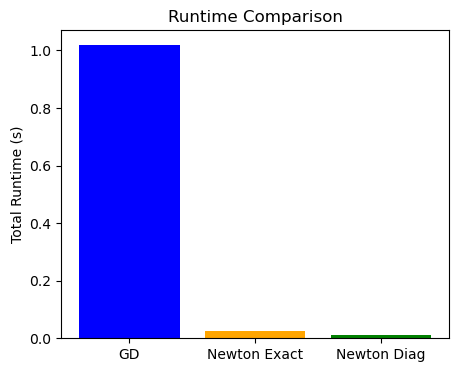

In [3]:
methods = ["GD", "Newton Exact", "Newton Diag"]
total_times = [gd_t[-1], nx_t[-1], nd_t[-1]]

plt.figure(figsize=(5,4))
plt.bar(methods, total_times, color=["blue","orange","green"])
plt.ylabel("Total Runtime (s)")
plt.title("Runtime Comparison")
plt.show()
